## What should be presented in the case study:

#### 1. Degree (strength) distribution


#### 2. Two of the following characteristics:

    2.1 Average path length

    2.2 Clustering coefficient

    2.3 Small-worldness


 #### 3. At least one of centrality measures: 

    3.1 Degree centrality￼

    3.2 Closeness centrality￼

    3.3 Betweenness

    3.4 Prestige

    3.5 Decay centrality

#### 4. You need to consider at least 2 networks

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy.stats import kstest, powerlaw
from functools import partial

In [2]:
options = {
    'node_color': 'lavender',
    'node_size': 500,
    'width': .3,
    'arrowsize': 10,
    'with_labels':True
}

# Data loading

In [3]:
path = "./data/"
fileName2019 = "EU_routes_2019.csv.gz"
fileName2022 = "EU_routes_2022.csv.gz"
fileAirports = "airports_clean.csv"
routes2019 = pd.read_csv(path + fileName2019)
routes2022 = pd.read_csv(path + fileName2022)
airports = pd.read_csv(path+fileAirports)
routes = {"2019": routes2019, "2022": routes2022}
years = ["2019", "2022"]

In [4]:
#create directed and undirected network object 
G2019_directed=nx.from_pandas_edgelist(routes2019, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2019_undirected = nx.from_pandas_edgelist(routes2019, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G2022_directed=nx.from_pandas_edgelist(routes2022, source = 'origin_IATA', target = 'destination_IATA', edge_attr= 'weight', create_using=nx.DiGraph())
G2022_undirected = nx.from_pandas_edgelist(routes2022, source = "origin_IATA", target = "destination_IATA", edge_attr= 'weight', create_using=nx.Graph())
G_directed = {"2019": G2019_directed, "2022": G2022_directed}
G_undirected = {"2019": G2019_undirected, "2022": G2022_undirected}
# Returns the biggest giant strongly connected component in the network
G2019_directed_connected = G2019_directed.subgraph(sorted(nx.strongly_connected_components(G2019_directed), key = len, reverse = True)[0])
G2022_directed_connected = G2022_directed.subgraph(sorted(nx.strongly_connected_components(G2022_directed), key = len, reverse = True)[0])
G_directed_connected = {"2019": G2019_directed_connected, "2022": G2022_directed_connected}
G2019_undirected_connected = G2019_undirected.subgraph(sorted(nx.connected_components(G2019_undirected), key = len, reverse = True)[0])
G2022_undirected_connected = G2022_undirected.subgraph(sorted(nx.connected_components(G2022_undirected), key = len, reverse = True)[0])
G_undirected_connected = {"2019": G2019_undirected_connected, "2022": G2022_undirected_connected}

# Data exploration

Using opensky-network.org's Covid-19 Dataset showing air-traffic for January 2019 and Oktober 2022

Considering Europe and excluding all flights that only appear once a month or take off and land on the same airfield to ensure data quality

We use the unique callsigns (indicating different carriers) of the flights as weights for multiple appearances

## Directed Network

In [26]:
# Using opensky-network.org's Covid-19 Dataset showing air-traffic for January 2019 and Oktober 2022
# Considering Europe and excluding all flights that only appear once a month
# Number of unique origin_IATA_IATAs
for year in years:
    print(f"{year:4}: {routes[year].origin_IATA.nunique():3} origins and {routes[year].destination_IATA.nunique():3} destinations with {routes[year].weight.count()} total routes that appeared on more than one day in the month")

2019: 425 origins and 467 destinations with 10722 total routes that appeared on more than one day in the month
2022: 505 origins and 546 destinations with 14053 total routes that appeared on more than one day in the month


## Undirected Network

In [27]:
for year in years:
    print(f"{year:4}: Number of nodes: {G_undirected[year].number_of_nodes()}; Number of routes/edges: {G_undirected[year].number_of_edges()}")

2019: Number of nodes: 491; Number of routes/edges: 6644
2022: Number of nodes: 563; Number of routes/edges: 8528


# Basic Network Metrics and Plots

In [8]:
#Produce adjecancy matrices for 2022 and 2022 for the directed network
adj2019 = nx.to_pandas_adjacency(G2019_undirected, dtype = int)
adj2022 = nx.to_pandas_adjacency(G2022_undirected, dtype = int)
adj2019.head()

,AAH,BNJ,QXH,AAL,AGP,ALC,AMS,BLL,BRE,CGN,...,SRP,ODH,TRF,POR,XMW,UTI,UHE,UIP,WBG,XCR
AAH,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BNJ,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
QXH,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAL,0,0,0,0,3,1,4,3,3,2,...,0,0,0,0,0,0,0,0,0,0
AGP,0,0,0,3,0,4,16,4,1,2,...,0,0,0,0,0,0,0,0,0,0


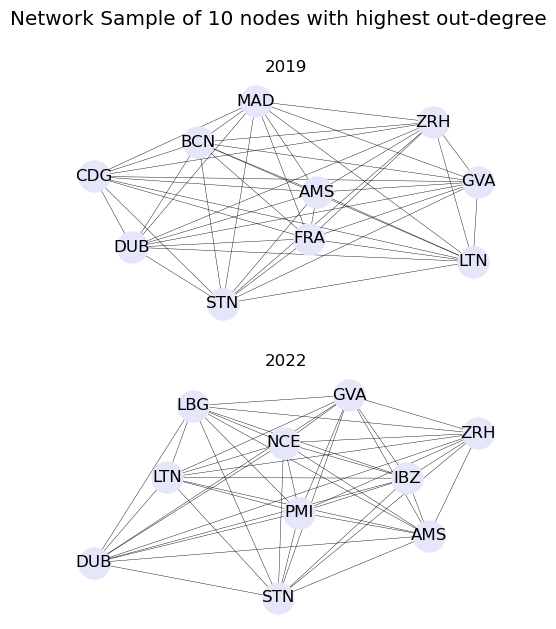

In [9]:
## Draw a sample network with the n nodes with the highest out degree

#Choose Number of nodes
n = 10
#Choose Graph to draw from
graph = G_undirected

fig, ax = plt.subplots(len(years), figsize = (6,7))
fig.suptitle(f"Network Sample of {n} nodes with highest out-degree", fontsize = "x-large")
i = 0
#Create and draw subgraph with n nodes
for year in years:
    degree = sorted(graph[year].degree, key = lambda x: x[1], reverse = True)[0:n]
    nodes = [node for node,_ in degree]
    G_sample = graph[year].subgraph(nodes)
    nx.draw(G_sample, ax = ax[i], **options)
    ax[i].set_title(year)
    i+=1

## Degree

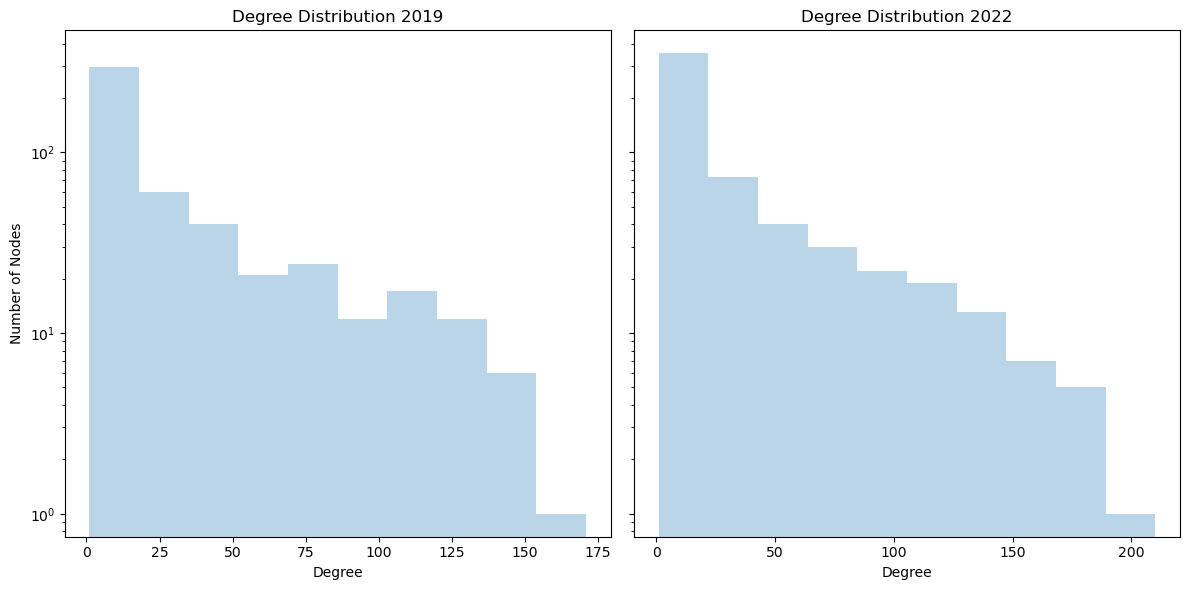

In [11]:
#caluculate in degrees 
degree2019 = dict(G2019_undirected.degree)
degree2022 = dict(G2022_undirected.degree)


fig, ax = plt.subplots(1,2, figsize = (12,6), sharey = True)

ax[0].hist(degree2019.values(), alpha=0.3, log = True, label = 'Degree')
ax[0].set_title('Degree Distribution 2019')

ax[1].hist(degree2022.values(),  alpha=0.3, log = True, label = 'Degree')
ax[1].set_title('Degree Distribution 2022')

for i in [0,1]:
    ax[i].set_xlabel("Degree")

ax[0].set_ylabel("Number of Nodes")

fig.tight_layout()

In [12]:
#description of the undirected graphs degree
degrees = pd.concat([pd.DataFrame.from_dict(degree2019, columns = ["2019"], orient = "index"), pd.DataFrame.from_dict(degree2022, columns = ["2022"], orient = "index")], axis = 1, join = "outer")
degrees.describe(percentiles=[.25,.5,.6,.7,.8,.9,.95])

,2019,2022
count,491.000000,563.000000
mean,27.063136,30.294849
std,36.371188,40.401038
min,1.000000,1.000000
25%,3.000000,4.000000
50%,9.000000,11.000000
60%,17.000000,19.000000
70%,28.000000,29.400000
80%,48.000000,56.000000
90%,85.000000,93.800000


In [11]:
in_degree2019 = dict(G2019_directed.in_degree)
in_degree2022 = dict(G2022_directed.in_degree)
out_degree2019 = dict(G2019_directed.out_degree)
out_degree2022 = dict(G2022_directed.out_degree)

columns = pd.MultiIndex.from_product([["In-Degree", "Out-Degree"], years], names = ["measure", "year"])
directed_degrees = pd.concat([pd.Series(in_degree2019.values()),
                    pd.Series(in_degree2022.values()), 
                    pd.Series(out_degree2019.values()), 
                    pd.Series(out_degree2022.values())], keys = columns, axis= 1)
directed_degrees.describe(percentiles=[.25,.5,.6,.7,.8,.9])

measure   In-Degree              Out-Degree            
year           2019        2022        2019        2022
count    491.000000  563.000000  491.000000  563.000000
mean      21.837067   24.960924   21.837067   24.960924
std       30.857109   34.943094   32.961975   36.764644
min        0.000000    0.000000    0.000000    0.000000
25%        2.000000    3.000000    1.000000    2.000000
50%        7.000000    8.000000    5.000000    7.000000
60%       11.000000   13.000000   11.000000   13.000000
70%       20.000000   24.000000   18.000000   22.000000
80%       41.000000   46.000000   39.000000   45.000000
90%       70.000000   82.000000   73.000000   84.000000
max      145.000000  192.000000  156.000000  192.000000

Mean is way higher than median --> there is some highly connected nodes --> hubs

In [12]:
#cannot confirm a powerlaw in degree distribution based on the p-value
degree2019_list = list(dict(degree2019).values())
fit = powerlaw.fit(degree2019_list)
a, loc, scale  = fit
kstest(degree2019_list, partial(powerlaw.cdf, a=a, loc=loc, scale=scale), alternative='two-sided')

KstestResult(statistic=0.26513575352174945, pvalue=5.886553528813591e-31)

In [13]:
#cannot confirm a powerlaw in degree distribution based on the p-value
degree2022_list = list(dict(degree2022).values())
fit = powerlaw.fit(degree2022_list)
a, loc, scale  = fit
kstest(degree2022_list, partial(powerlaw.cdf, a=a, loc=loc, scale=scale), alternative='two-sided')

KstestResult(statistic=0.3657705265704983, pvalue=4.962419098957249e-68)

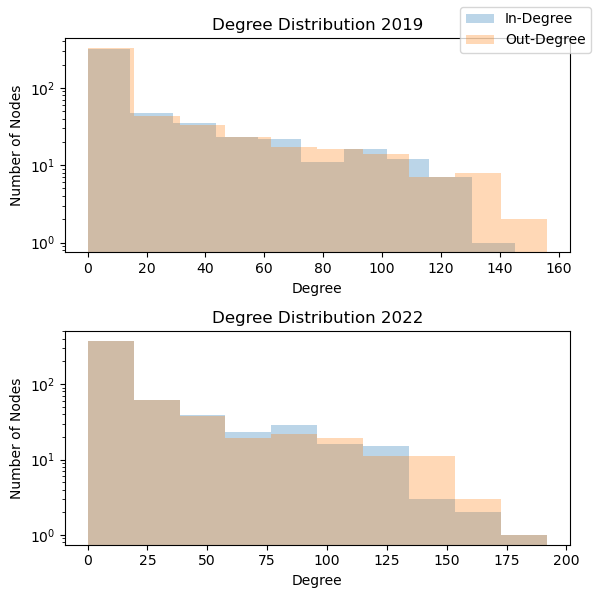

In [19]:
fig, ax = plt.subplots(2,1, figsize = (6,6))

ax[0].hist(degree2019.values(), alpha=0.3, log = True, label = 'In-Degree')
ax[0].hist(out_degree2019.values(), alpha=0.3, log = True, label = 'Out-Degree')
ax[0].set_title('Degree Distribution 2019')

ax[1].hist(degree2022.values(),  alpha=0.3, log = True, label = 'In-Degree')
ax[1].hist(out_degree2022.values(),  alpha=0.3, log = True, label = 'Out-Degree')
ax[1].set_title('Degree Distribution 2022')

for i in [0,1]:
    ax[i].set_xlabel("Degree")
    ax[i].set_ylabel("Number of Nodes")


fig.legend(["In-Degree", "Out-Degree"])
fig.tight_layout()

## Strength

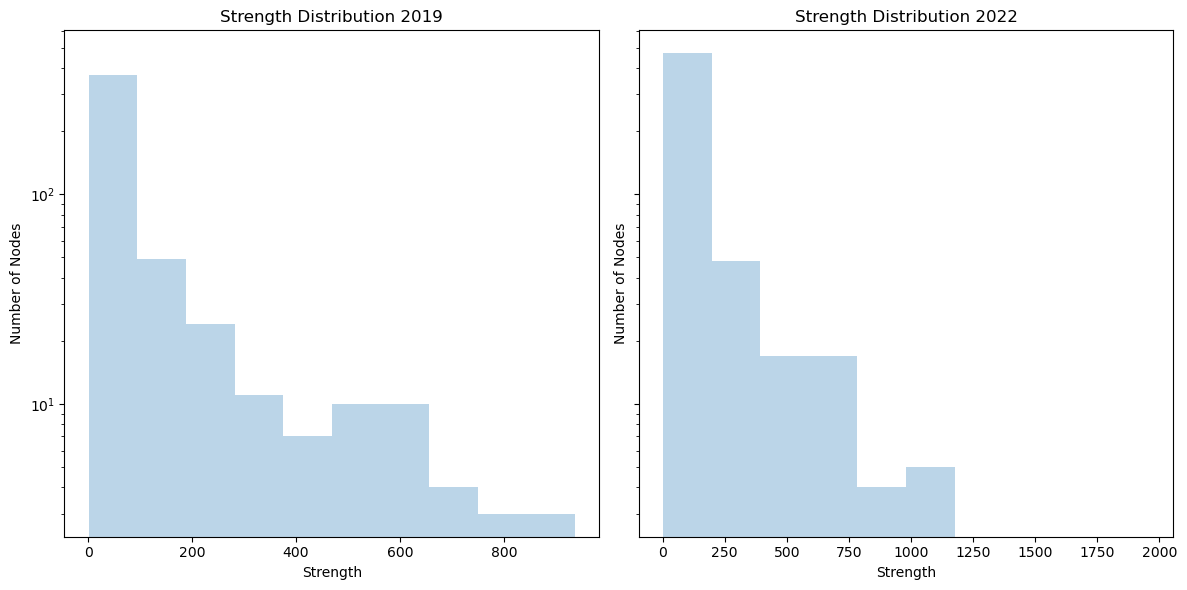

In [16]:
#strength distribution
strength2019 = dict(G2019_undirected.degree(weight = 'weight'))
strength2022 = dict(G2022_undirected.degree(weight = 'weight'))

fig, ax = plt.subplots(1,2, figsize = (12,6), sharey = True)

ax[0].hist(strength2019.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
ax[0].set_title('Strength Distribution 2019')

ax[1].hist(strength2022.values(), bins = 10, alpha=0.3, log = True, label = 'In-Strength')
ax[1].set_title('Strength Distribution 2022')

for i in [0,1]:
    ax[i].set_xlabel("Strength")
    ax[i].set_ylabel("Number of Nodes")

fig.tight_layout()


In [20]:
max_strength = max(strength2019, key=strength2019.get)
print(f"Max Strength 2019 is at {max_strength} with {strength2019[max_strength]}.")

Max Strength 2019 is at AMS with 936.


In [21]:
max_strength = max(strength2022, key=strength2022.get)
print(f"Max Strength 2022 is at {max_strength} with {strength2022[max_strength]}.")

Max Strength 2022 is at PMI with 1959.


## Distance measures

In [22]:
from networkx.algorithms.distance_measures import diameter
from networkx import average_shortest_path_length

In [25]:
#Calculate the diameter:
for year in years:
    print(f"Diameter of european flight network {year}: {diameter(G_undirected_connected[year])}")


Diameter of european flight network 2019: 7
Diameter of european flight network 2022: 6


In [26]:
#Calculate the diameter (-||-)
for year in years:
    print(f"Average shortest path length of european flight network {year}: {average_shortest_path_length(G_undirected_connected[year]):.4f}")

Average shortest path length of european flight network 2019: 2.6389
Average shortest path length of european flight network 2022: 2.5666


## Centrality

In [29]:
from collections import defaultdict

In [17]:
#join SXF and BER into one line for plotting and comparisson
def get_berlin(df):
    ber = pd.DataFrame(df.loc[["SXF", "BER"],:].sum().rename("BER/SXF")).T
    df = pd.concat([df, ber]).drop(["BER", "SXF"], axis = 0)
    return df

In [30]:
#create a nested dictionary for centrality measures and years
centrality_measures = {"degree_centrality": nx.centrality.degree_centrality, #how connected the node is
                        "betweenness_centrality": nx.centrality.betweenness_centrality, #how important the node is in terms of connecting other nodes
                        "closeness_centrality": nx.centrality.closeness_centrality} #how easily a node can reach other nodes
columns = pd.MultiIndex.from_product([years, list(centrality_measures.keys())], names = ["year", "measure"])
index = [1, 2019, 2022]
centrality_values = defaultdict(dict)
for name, func in centrality_measures.items():
    for year in years:
        centr = dict(func(G_undirected[year]))
        centrality_values[name][year] = centr

#reshape the nested dictionary into multi index dataframe
reformed_dict = {}
for outerKey, innerDict in centrality_values.items():
    for innerKey, values in innerDict.items():
        reformed_dict[(outerKey,
                       innerKey)] = values
        
centrality_values_df = pd.DataFrame(reformed_dict)

centrality_values_df = get_berlin(centrality_values_df)

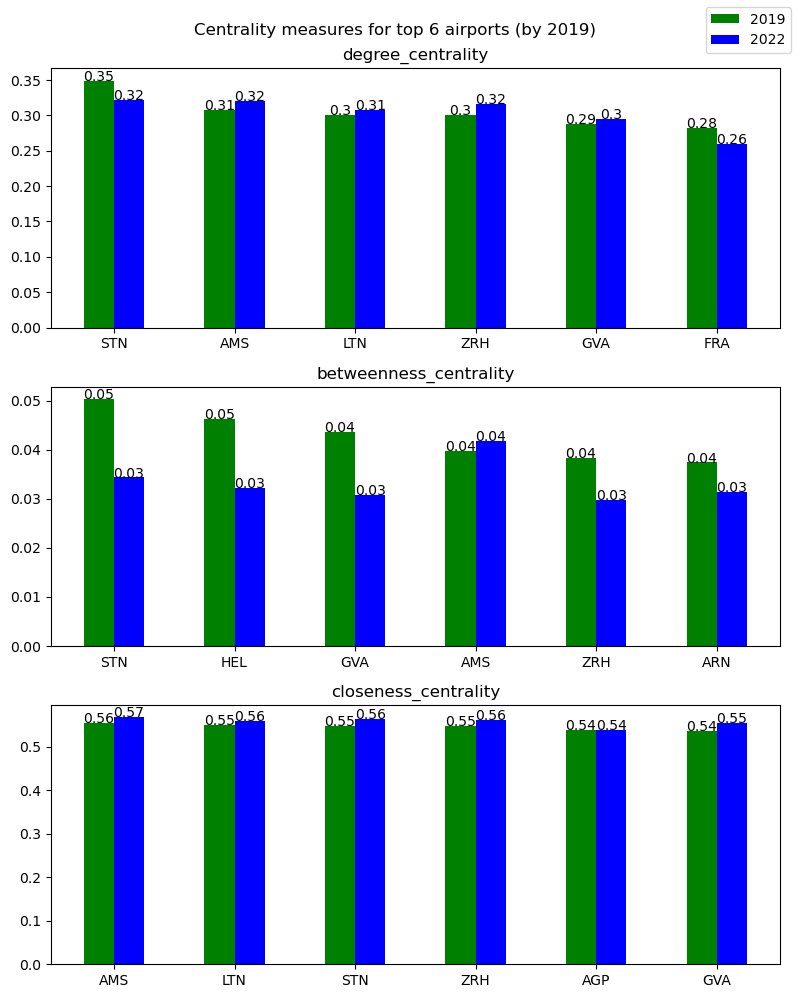

In [30]:
# centrality barplot for top n airports
n = 6
fig, ax = plt.subplots(3,1, figsize= (8,10))
x_axis = np.arange(n)
for i, measure in enumerate(centrality_measures.keys()):
    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i].bar(x = x_axis-0.125, height=df["2019"], label = "2019", width = 0.25, color = "green")
    ax[i].bar(x = x_axis+0.125, height=df["2022"], label = "2022", width = 0.25, color = "blue")
    ax[i].set_xticks(x_axis, df.index)
    ax[i].set_title(measure)
    
    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[i].text(x = ii - .125,y = val2019, s = str(round(val2019,2)), color='black', horizontalalignment = "center")
        ax[i].text(x = ii + .125,y = val2022, s = str(round(val2022,2)), color='black', horizontalalignment = "center")
    
fig.suptitle(f"Centrality measures for top {n} airports (by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  

# Network Density

In [31]:
for year in years:
    print("Network Density in", year, ": ", nx.density(G_undirected[year]))

Network Density in 2019 :  0.055230890726962883
Network Density in 2022 :  0.05390542530799037


# Clustering

In [32]:
for year in years:
    print("Average Clustering Coefficient in", year, ": ", nx.average_clustering(G_undirected[year]))

Average Clustering Coefficient in 2019 :  0.44558800029542706
Average Clustering Coefficient in 2022 :  0.500743644762706


# BER Calculations

In [7]:
#Create a dictionary with the berlin Airports
berlin_airports = {}
for year in years:
    berlin_airports[year] = [x for x in routes[year].origin_IATA.loc[routes[year]["origin_city"] == "Berlin"].unique()]

berlin_airports

{'2019': ['SXF', 'TXL'], '2022': ['BER']}

In [8]:
# Clustering Coefficient for BER/SXF
clustering = {}
for year in years:
    clustering[year] = nx.clustering(G_directed[year], berlin_airports[year])

clustering

{'2019': {'SXF': 0.4006578296567415, 'TXL': 0.45493110949963744},
 '2022': {'BER': 0.4442460609630393}}

In [37]:
ber_centrality = centrality_values_df.loc[["BER/SXF", "TXL"],:]
ber_centrality

degree_centrality           betweenness_centrality            \
                     2019      2022                   2019      2022   
BER/SXF          0.242857  0.243772               0.015571  0.010689   
TXL              0.195918       NaN               0.007782       NaN   

        closeness_centrality            
                        2019      2022  
BER/SXF             0.523380  0.534777  
TXL                 0.497968       NaN

posx and posy should be finite values
posx and posy should be finite values


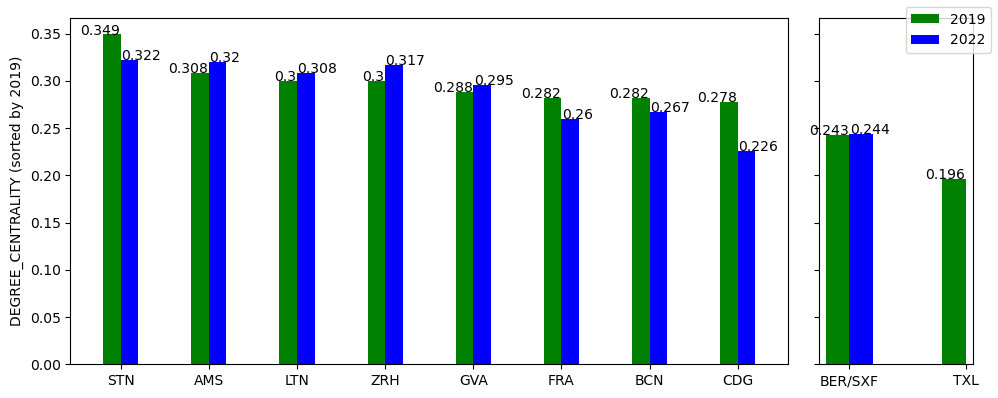

posx and posy should be finite values
posx and posy should be finite values


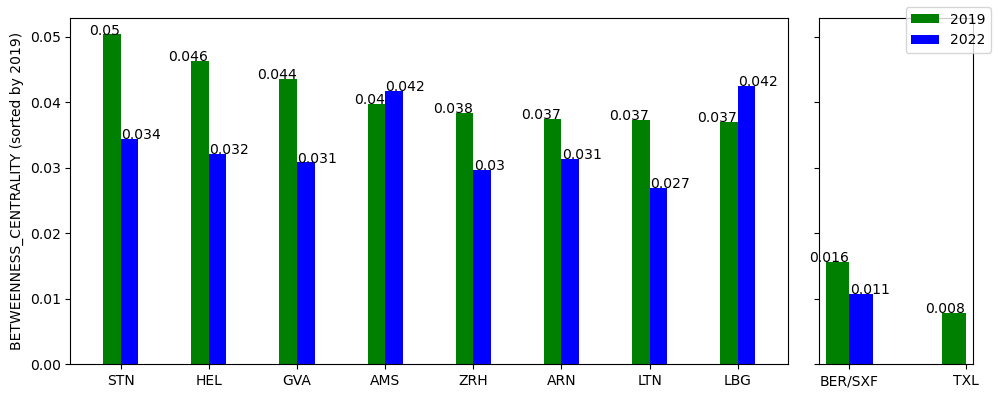

posx and posy should be finite values
posx and posy should be finite values


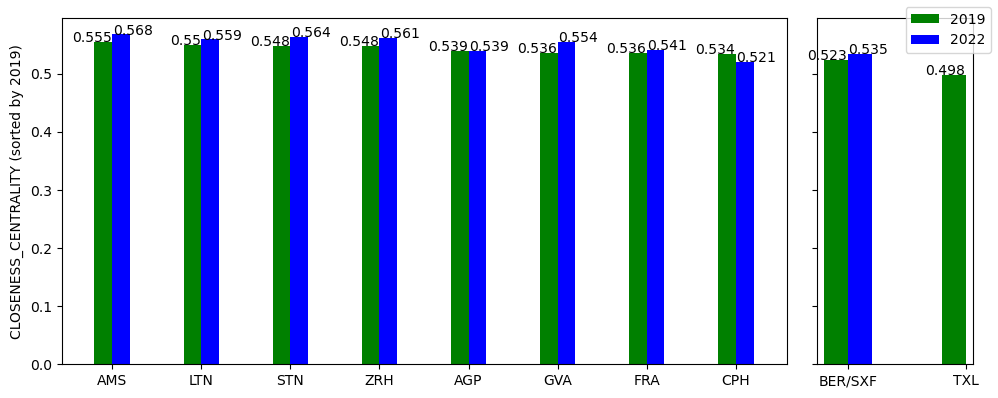

In [59]:
n = 8


for i, measure in enumerate(centrality_measures.keys()):
    fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = "row", gridspec_kw={'width_ratios': [n-1,1.5]})
    x_axis = np.arange(len(ber_centrality))
    df = ber_centrality[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[1].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[1].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[1].set_xticks(x_axis, df.index)

    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[1].text(x = ii - .005,y = val2019, s = str(round(val2019,3)), color='black', horizontalalignment = "right")
        ax[1].text(x = ii + .005,y = val2022, s = str(round(val2022,3)), color='black', horizontalalignment = "left")
    #ax[i,1].set_title(measure)
    

    x_axis = np.arange(n)

    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[ 0].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[ 0].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[ 0].set_xticks(x_axis, df.index)
    ax[0].set_ylabel(f"{measure.upper()} (sorted by 2019)")

    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[0].text(x = ii - .005,y = val2019, s = str(round(val2019,3)), color='black', horizontalalignment = "right")
        ax[0].text(x = ii + .005,y = val2022, s = str(round(val2022,3)), color='black', horizontalalignment = "left")
    
    #fig.suptitle(f"{measure.upper()} (sorted by 2019)")
    fig.legend([2019,2022])
    fig.tight_layout()

plt.show()  
    

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


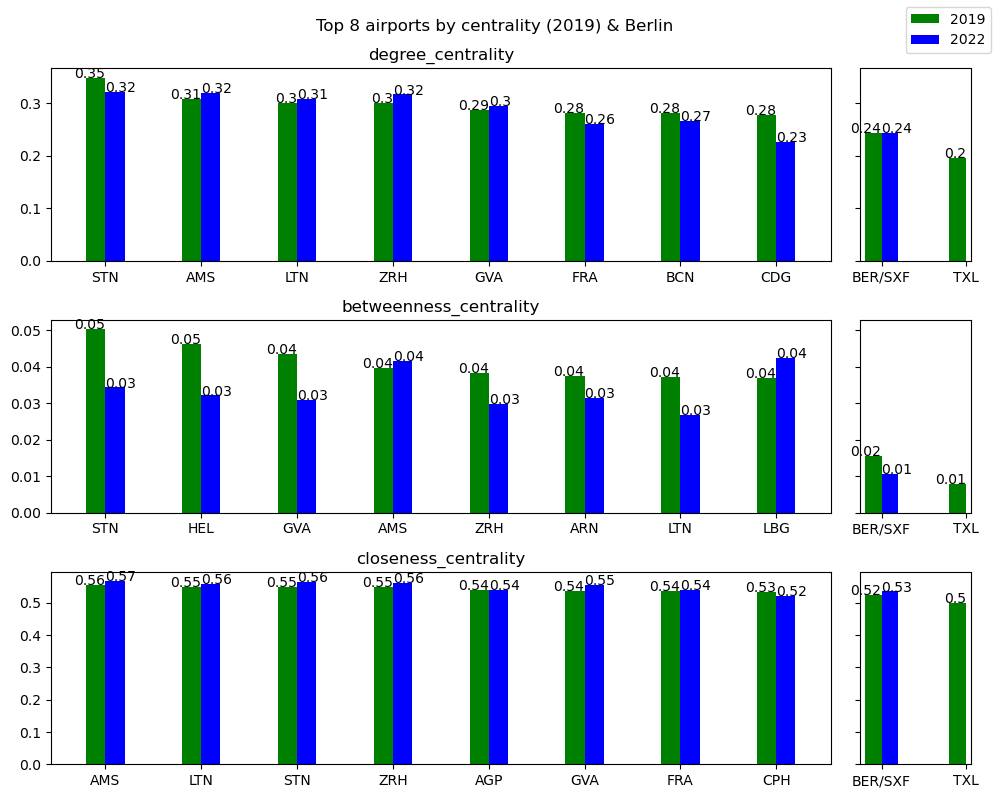

In [37]:
n = 8
fig, ax = plt.subplots(3,2, figsize = (10,8), sharey = "row", gridspec_kw={'width_ratios': [n-1,1]})

for i, measure in enumerate(centrality_measures.keys()):
    
    x_axis = np.arange(len(ber_centrality))
    df = ber_centrality[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i,1].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i,1].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i,1].set_xticks(x_axis, df.index)

    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[i,1].text(x = ii,y = val2019, s = str(round(val2019,2)), color='black', horizontalalignment = "right")
        ax[i,1].text(x = ii,y = val2022, s = str(round(val2022,2)), color='black', horizontalalignment = "left")
    #ax[i,1].set_title(measure)
    

    x_axis = np.arange(n)

    df = centrality_values_df[measure]
    df = df.sort_values(ascending = False, by = "2019")[:n]
    
    
    ax[i, 0].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i, 0].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i, 0].set_xticks(x_axis, df.index)
    ax[i, 0].set_title(measure)

    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[i,0].text(x = ii,y = val2019, s = str(round(val2019,2)), color='black', horizontalalignment = "right")
        ax[i,0].text(x = ii,y = val2022, s = str(round(val2022,2)), color='black', horizontalalignment = "left")
    
fig.suptitle(f"Top {n} airports by centrality (2019) & Berlin")
fig.legend([2019,2022])
fig.tight_layout()

plt.show()  
    

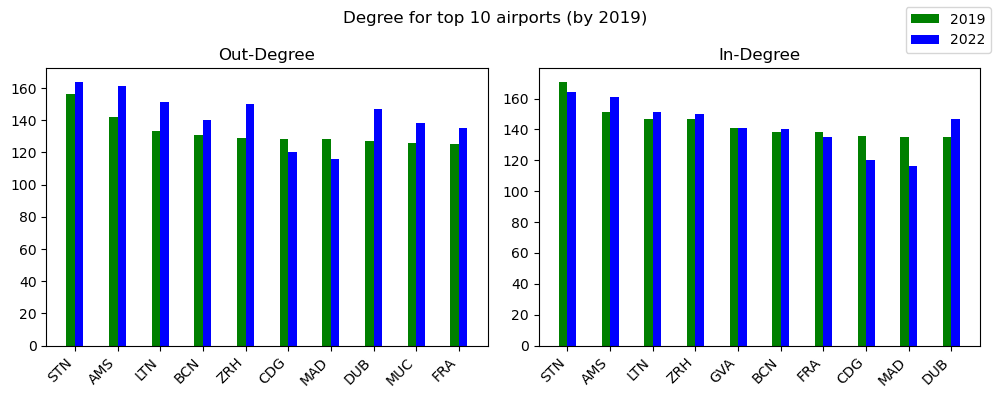

In [38]:
# out-degree barplot for top n aiports

#number of top airports to compare
n = 10
fig, ax = plt.subplots(1,2, figsize= (n,4))
x_axis = np.arange(n)
out_degree = pd.DataFrame.from_dict(out_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

in_degree = pd.DataFrame.from_dict(degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

out_degree = get_berlin(out_degree)#.loc[["BER/SXF", "TXL"],:]
in_degree = get_berlin(in_degree)#.loc[["BER/SXF", "TXL"],:]

# in_degree.drop(["BER", "SXF", "TXL"], inplace=True)
# out_degree.drop(["BER", "SXF", "TXL"], inplace=True)

x_axis_ber = np.arange(n+1,n+3)

degrees = {"Out-Degree": out_degree.sort_values(ascending = False, by = "2019")[:n], "In-Degree": in_degree.sort_values(ascending = False, by = "2019")[:n]}
#degrees_ber = {"Out-Degree": out_degree_ber, "In-Degree": in_degree_ber}

for number, (name, df) in enumerate(degrees.items()):
    ax[number].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[number].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[number].set_xticks(x_axis, df.index)
    ax[number].set_xticklabels(ax[number].get_xticklabels(), rotation = 45, ha = "right")
    ax[number].set_title(name)

    
# #add Berlin seperately
# for number, (name, df) in enumerate(degrees_ber.items()):
#     ax[number].bar(x = x_axis_ber-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
#     ax[number].bar(x = x_axis_ber+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
#     ax[number].set_title(name)
    
fig.suptitle(f"Degree for top {n} airports (by 2019)")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  


In [14]:
#calculate out degree for Berlin as a City
dest2022 = pd.Series([i for i in G2022_directed.successors("BER")]).nunique()
dest2019 = pd.Series([i for i in G2019_directed.successors("SXF")] + [i for i in G2019_directed.successors("TXL")]).nunique()
print(f"From Berlin you could nonstop reach {dest2019} destinations in 2019 and {dest2022} in 2022 (out-degree).")

# calculate in-degree for Berlin as a city
sour2022 = pd.Series([i for i in G2022_directed.predecessors("BER")]).nunique()
sour2019 = pd.Series([i for i in G2019_directed.predecessors("SXF")] + [i for i in G2019_directed.predecessors("TXL")]).nunique()
print(f"You could reach Berlin nonstop from {dest2019} origins in 2019 and {dest2022} in 2022 (in-degree).")

From Berlin you could nonstop reach 135 destinations in 2019 and 117 in 2022 (out-degree).
You could reach Berlin nonstop from 135 origins in 2019 and 117 in 2022 (in-degree).


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


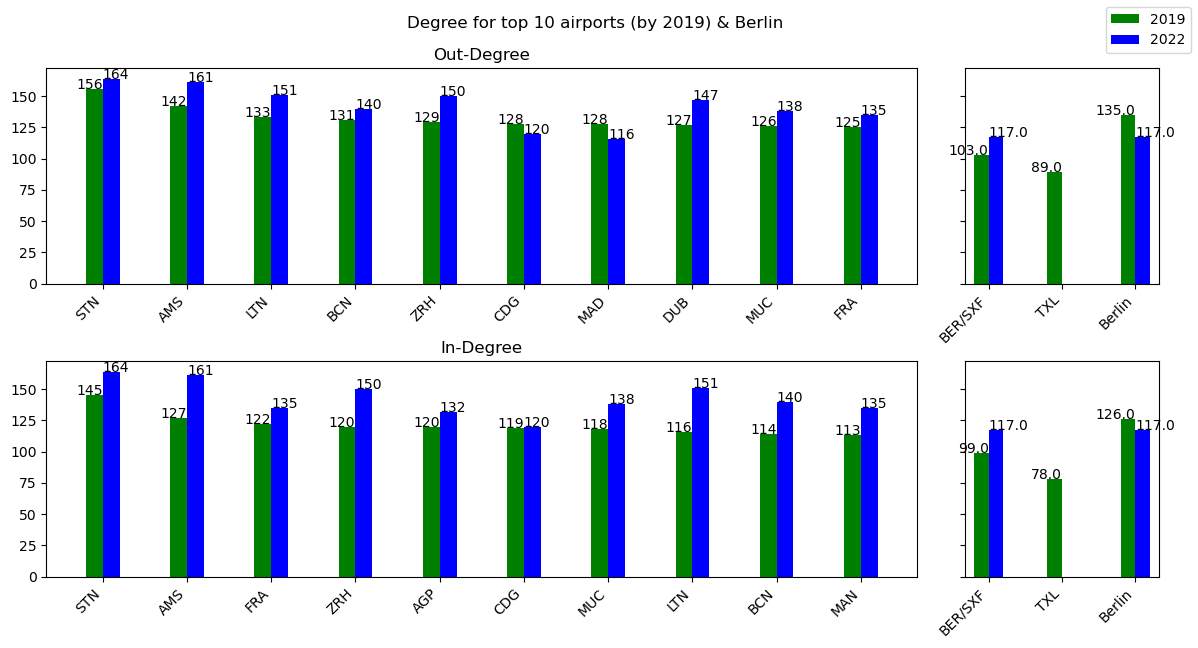

In [53]:
# out-degree barplot for top n aiports

#caluculate in degrees 
in_degree2019 = dict(G2019_directed.in_degree)
in_degree2022 = dict(G2022_directed.in_degree)
#out degree
out_degree2019 = dict(G2019_directed.out_degree)
out_degree2022 = dict(G2022_directed.out_degree)

#number of top airports to compare
n = 10
fig, ax = plt.subplots(2,2, figsize= (n+2,6.5), sharey = True, gridspec_kw={'width_ratios': [n-1,2]})
x_axis = np.arange(n)
out_degree = pd.DataFrame.from_dict(out_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

in_degree = pd.DataFrame.from_dict(in_degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(out_degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

out_degree_ber = get_berlin(out_degree).loc[["BER/SXF", "TXL"],:]
in_degree_ber = get_berlin(in_degree).loc[["BER/SXF", "TXL"],:]

out_degree_ber.loc["Berlin",:] = [dest2019, dest2022]
in_degree_ber.loc["Berlin",:] = [sour2019, sour2022]

in_degree.drop(["BER", "SXF", "TXL"], inplace=True)
out_degree.drop(["BER", "SXF", "TXL"], inplace=True)

x_axis_ber = np.arange(out_degree_ber.__len__())

degrees = {"Out-Degree": out_degree.sort_values(ascending = False, by = "2019")[:n], "In-Degree": in_degree.sort_values(ascending = False, by = "2019")[:n]}
degrees_ber = {"Out-Degree": out_degree_ber, "In-Degree": in_degree_ber}

for i, (name, df) in enumerate(degrees.items()):
    ax[i,0].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i,0].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i,0].set_xticks(x_axis, df.index)
    ax[i,0].set_xticklabels(ax[i,0].get_xticklabels(), rotation = 45, ha = "right")
    ax[i,0].set_title(name)

    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[i,0].text(x = ii,y = val2019, s = str(int(val2019)), color='black', horizontalalignment = "right")
        ax[i,0].text(x = ii,y = val2022, s = str(int(val2022)), color='black', horizontalalignment = "left")

    
#add Berlin seperately
for i, (name, df) in enumerate(degrees_ber.items()):
    ax[i,1].bar(x = x_axis_ber-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[i,1].bar(x = x_axis_ber+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[i,1].set_xticks(x_axis_ber, df.index)
    ax[i,1].set_xticklabels(ax[i,1].get_xticklabels(), rotation = 45, ha = "right")
    
    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[i,1].text(x = ii,y = val2019, s = str((val2019)), color='black', horizontalalignment = "right")
        ax[i,1].text(x = ii,y = val2022, s = str((val2022)), color='black', horizontalalignment = "left")


fig.suptitle(f"Degree for top {n} airports (by 2019) & Berlin")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  


posx and posy should be finite values
posx and posy should be finite values


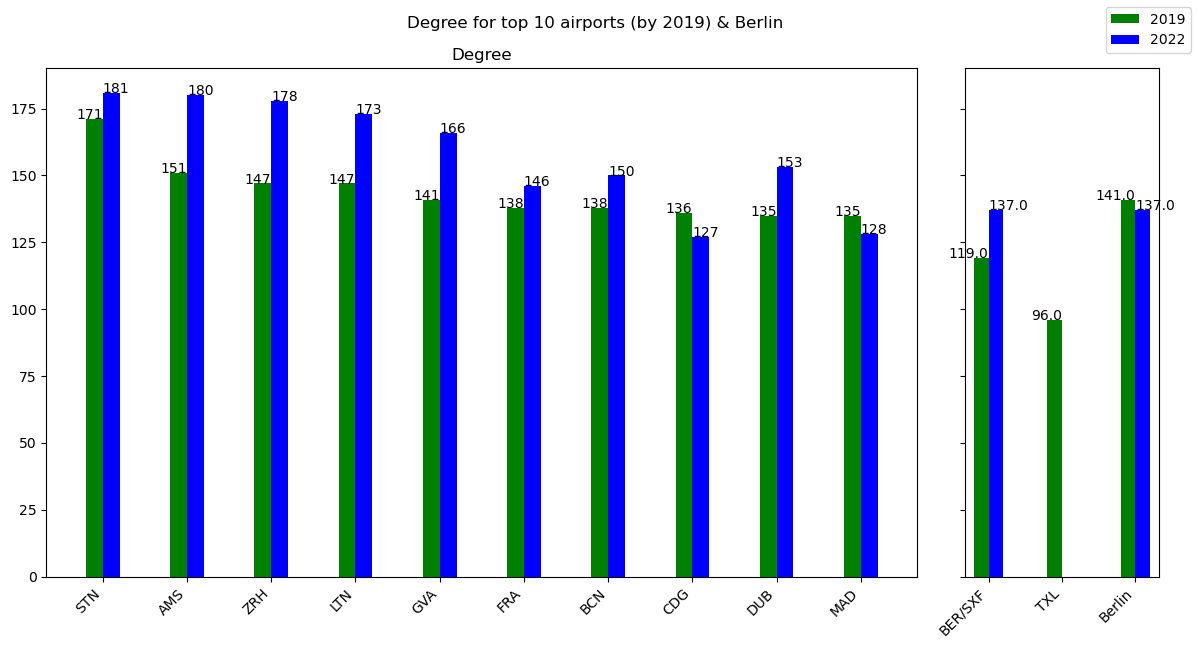

In [26]:
# degree barplot for top n aiports

#caluculate in degrees 
degree2019 = dict(G2019_undirected.degree)
degree2022 = dict(G2022_undirected.degree)

#number of top airports to compare
n = 10
fig, ax = plt.subplots(1,2, figsize= (n+2,6.5), sharey = True, gridspec_kw={'width_ratios': [n-1,2]})
x_axis = np.arange(n)

degree = pd.DataFrame.from_dict(degree2019, orient = "index", columns = ["2019"]). \
                    merge(pd.DataFrame.from_dict(degree2022, orient = "index", columns = ["2022"]), left_index=True, right_index=True, how = "outer")

#out_degree_ber = get_berlin(out_degree).loc[["BER/SXF", "TXL"],:]
degree_ber = get_berlin(degree).loc[["BER/SXF", "TXL"],:]

sour2022 = pd.Series([i for i in G2022_undirected.neighbors("BER")]).nunique()
sour2019 = pd.Series([i for i in G2019_undirected.neighbors("SXF")] + [i for i in G2019_directed.predecessors("TXL")]).nunique()
degree_ber.loc["Berlin",:] = [sour2019, sour2022]

degree.drop(["BER", "SXF", "TXL"], inplace=True)

x_axis_ber = np.arange(degree_ber.__len__())

degrees = {"Degree": degree.sort_values(ascending = False, by = "2019")[:n]}
degrees_ber = {"Degree": degree_ber}
degrees_ber["Degree"]

for i, (name, df) in enumerate(degrees.items()):
    ax[0].bar(x = x_axis-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[0].bar(x = x_axis+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[0].set_xticks(x_axis, df.index)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45, ha = "right")
    ax[0].set_title(name)

    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[0].text(x = ii,y = val2019, s = str(int(val2019)), color='black', horizontalalignment = "right")
        ax[0].text(x = ii,y = val2022, s = str(int(val2022)), color='black', horizontalalignment = "left")

    
#add Berlin seperately
for i, (name, df) in enumerate(degrees_ber.items()):
    ax[1].bar(x = x_axis_ber-0.1, height=df["2019"], label = "2019", width = 0.2, color = "green")
    ax[1].bar(x = x_axis_ber+0.1, height=df["2022"], label = "2022", width = 0.2, color = "blue")
    ax[1].set_xticks(x_axis_ber, df.index)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha = "right")
    
    for ii, (iata, val2019, val2022) in enumerate(df.itertuples()):
        ax[1].text(x = ii,y = val2019, s = str((val2019)), color='black', horizontalalignment = "right")
        ax[1].text(x = ii,y = val2022, s = str((val2022)), color='black', horizontalalignment = "left")


fig.suptitle(f"Degree for top {n} airports (by 2019) & Berlin")
fig.legend([2019,2022])
fig.tight_layout()
plt.show()  


In [47]:
out_degree_ber

,2019,2022
BER/SXF,103.0,117.0
TXL,89.0,NaN
Berlin,135.0,117.0


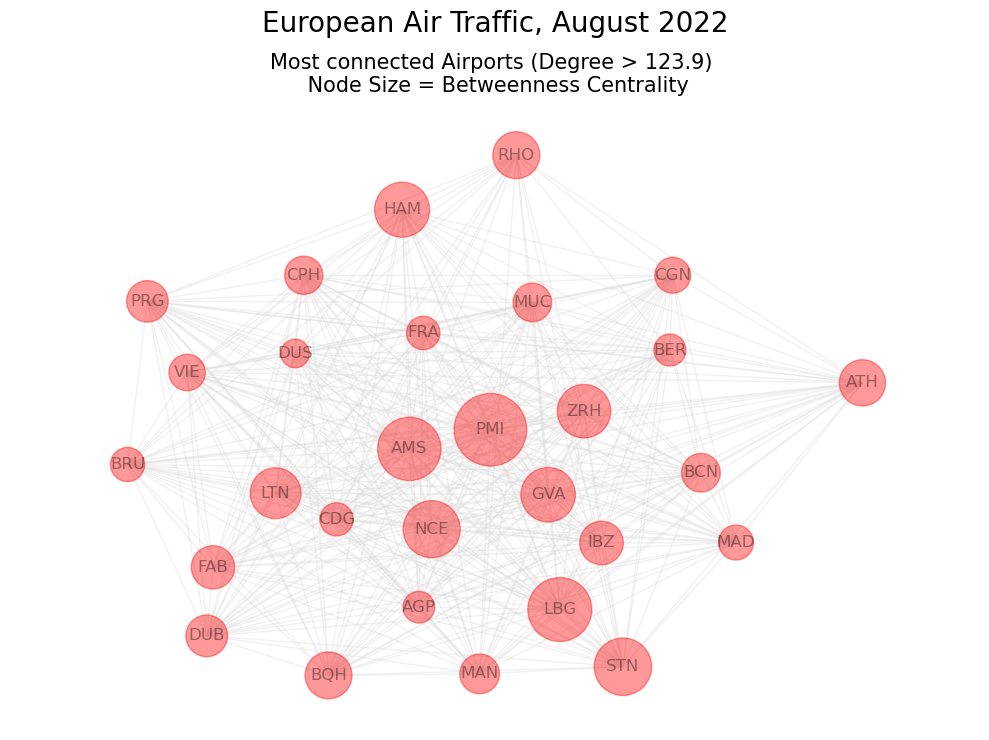

In [33]:
G_draw = G2022_undirected.copy()
min_degree = 123.9
year = "2022"

# remove low-degree nodes and compute centrality values
nodes_draw = [n for n, d in G_draw.degree() if d > min_degree]
nodes_draw[nodes_draw.index("BER")] = "BER/SXF"
centr = centrality_values_df.loc[nodes_draw,("betweenness_centrality", year)]
nodes_draw[nodes_draw.index("BER/SXF")] = "BER"
G_draw = G_draw.subgraph(nodes_draw)
node_size = [v * 50000 for v in centr.values]


#### draw graph ####
fig, ax = plt.subplots(figsize=(10, 7.5))
pos = nx.spring_layout(G_draw, k=2, seed=4572321)
node_color = "red"

nx.draw_networkx(
    G_draw,
    pos=pos,
    nodelist = nodes_draw,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
#font = {"color": "black", "fontsize": 20}
fig.suptitle(f"European Air Traffic, August {year}", fontsize = 20)
ax.set_title(f"Most connected Airports (Degree > {min_degree}) \n Node Size = Betweenness Centrality", fontsize = 15)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()



In [ ]:
#Nonstop destinations from Berlin in 2019 and 2022

In [12]:
#Clustering Values with average in the graph
avg_clustering_coeff = {"2019": nx.average_clustering(G2019_undirected), "2022": nx.average_clustering(G2022_undirected)}
other_airports = ["STN", "MUC", "AMS"]
# Clustering Coefficient for BER/SXF
clustering = {}
for year in years:
    nodes = berlin_airports[year] + other_airports
    clustering[year] = nx.clustering(G_undirected[year], nodes=nodes)

clustering

{'2019': {'SXF': 0.39709443099273606,
  'TXL': 0.4456140350877193,
  'STN': 0.26921224630202956,
  'MUC': 0.37896981259117946,
  'AMS': 0.33536423841059604},
 '2022': {'BER': 0.42528982395878057,
  'STN': 0.2881522406384285,
  'MUC': 0.36859305125558994,
  'AMS': 0.30415890751086283}}

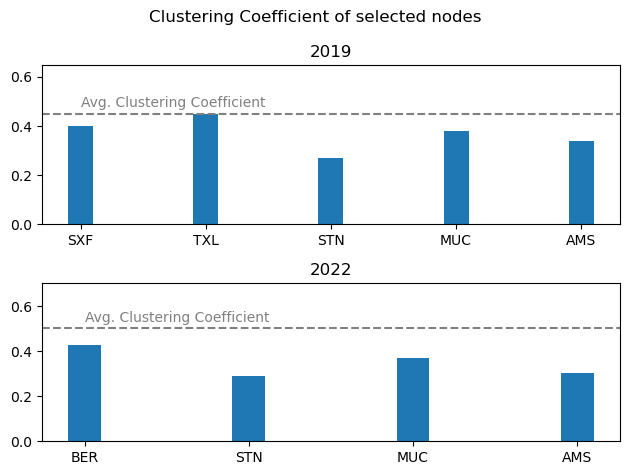

In [13]:
fig, ax = plt.subplots(2,1)

for i, year in enumerate(years):
    clust = clustering[year]
    x_axis = np.arange(len(clustering[year]))
    ax[i].bar(x = x_axis, height = clust.values(), width = 0.2)
    ax[i].set_xticks(x_axis, clust.keys())
    ax[i].axhline(avg_clustering_coeff[year], color = "grey", linestyle = "dashed")
    ax[i].text(0, avg_clustering_coeff[year]+0.03, "Avg. Clustering Coefficient", color = "grey", horizontalalignment = "left")
    ax[i].set_ylim(0.0, avg_clustering_coeff[year]+0.2)
    ax[i].set_title(year)

fig.suptitle("Clustering Coefficient of selected nodes")
fig.tight_layout()

In [13]:
centrality_values_df.loc[["BER/SXF", "TXL", "STN", "AMS", "MUC"],:]

degree_centrality           betweenness_centrality            \
                     2019      2022                   2019      2022   
BER/SXF          0.242857  0.243772               0.015571  0.010689   
TXL              0.195918       NaN               0.007782       NaN   
STN              0.348980  0.322064               0.050331  0.034342   
AMS              0.308163  0.320285               0.039766  0.041716   
MUC              0.273469  0.272242               0.018086  0.015432   

        closeness_centrality            
                        2019      2022  
BER/SXF             0.523380  0.534777  
TXL                 0.497968       NaN  
STN                 0.548388  0.563610  
AMS                 0.555337  0.567652  
MUC                 0.532633  0.538938

In [15]:
degrees.loc[["BER", "SXF", "TXL", "STN", "AMS", "MUC"],:]

,2019,2022
BER,NaN,137.0
SXF,119.0,NaN
TXL,96.0,NaN
STN,171.0,181.0
AMS,151.0,180.0
MUC,134.0,153.0
